In [1]:
# imports

# Standard
from pathlib import Path
import json
import logging

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Utils
from tqdm import tqdm
from rich.console import Console
from rich.table import Table

console = Console()

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger(__name__)

sns.set_style("whitegrid")

In [2]:
# define base paths

PROJECT_ROOT = Path("../").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "COCO"

TRAIN_IMG_DIR = DATA_DIR / "train2014"
VAL_IMG_DIR = DATA_DIR / "val2014"
ANNOTATIONS_DIR = DATA_DIR / "annotations"

CAPTIONS_TRAIN = ANNOTATIONS_DIR / "captions_train2014.json"
CAPTIONS_VAL = ANNOTATIONS_DIR / "captions_val2014.json"

assert TRAIN_IMG_DIR.exists(), "Train image directory missing"
assert CAPTIONS_TRAIN.exists(), "Captions file missing"

logger.info("All paths verified successfully.")

2026-02-18 01:07:56,530 - INFO - All paths verified successfully.


In [3]:
# load annotations json

with open(CAPTIONS_TRAIN) as f:
    train_data = json.load(f)

with open(CAPTIONS_VAL) as f:
    val_data = json.load(f)

logger.info("Annotation files loaded.")

2026-02-18 01:07:56,884 - INFO - Annotation files loaded.


In [4]:
# basic datasets

num_images = len(train_data["images"])
num_annotations = len(train_data["annotations"])

console.print(f"[bold green]Train Images:[/bold green] {num_images}")
console.print(f"[bold blue]Train Captions:[/bold blue] {num_annotations}")

captions_per_image = num_annotations / num_images
console.print(f"[bold yellow]Captions per Image:[/bold yellow] {captions_per_image:.2f}")

Train Images: 82783

Train Captions: 414113

Captions per Image: 5.00

In [5]:
# convert to dataframe for easier analysis

images_df = pd.DataFrame(train_data["images"])
annotations_df = pd.DataFrame(train_data["annotations"])

merged_df = annotations_df.merge(
    images_df[["id", "file_name"]],
    left_on="image_id",
    right_on="id",
    how="left"
)

merged_df["image_path"] = merged_df["file_name"].apply(
    lambda x: TRAIN_IMG_DIR / x
)

assert merged_df["image_path"].iloc[0].exists(), "Image path mapping failed"

merged_df.head()

,image_id,id_x,caption,id_y,file_name,image_path
0,318556,48,A very clean and well decorated empty bathroom,318556,COCO_train2014_000000318556.jpg,/home/saber/Wox/ANLP/multimodal_ai/data/COCO/t...
1,116100,67,A panoramic view of a kitchen and all of its a...,116100,COCO_train2014_000000116100.jpg,/home/saber/Wox/ANLP/multimodal_ai/data/COCO/t...
2,318556,126,A blue and white bathroom with butterfly theme...,318556,COCO_train2014_000000318556.jpg,/home/saber/Wox/ANLP/multimodal_ai/data/COCO/t...
3,116100,148,A panoramic photo of a kitchen and dining room,116100,COCO_train2014_000000116100.jpg,/home/saber/Wox/ANLP/multimodal_ai/data/COCO/t...
4,379340,173,A graffiti-ed stop sign across the street from...,379340,COCO_train2014_000000379340.jpg,/home/saber/Wox/ANLP/multimodal_ai/data/COCO/t...


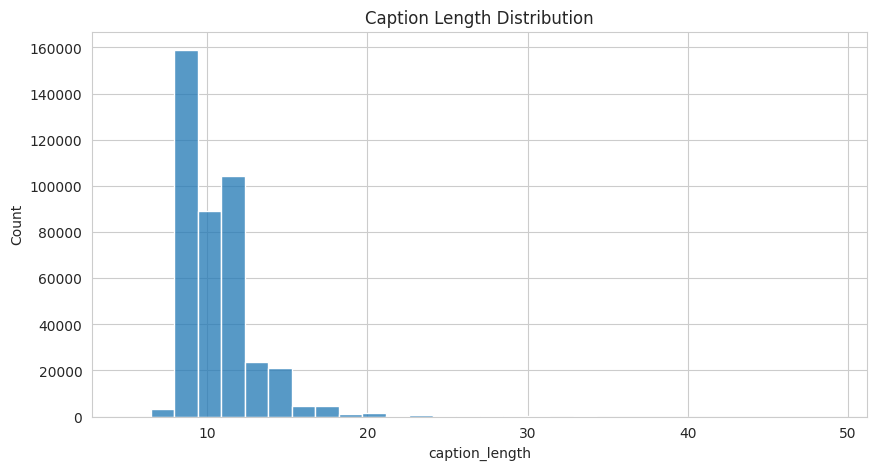

In [6]:
# caption length distribution

merged_df["caption_length"] = merged_df["caption"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(merged_df["caption_length"], bins=30)
plt.title("Caption Length Distribution")
plt.show()

In [7]:
fig = px.histogram(
    merged_df,
    x="caption_length",
    nbins=30,
    title="Interactive Caption Length Distribution"
)
fig.show()

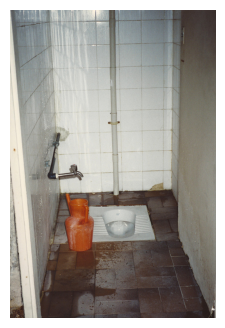

Caption: A bathroom has an orange pitcher by a faucet.

Image: /home/saber/Wox/ANLP/multimodal_ai/data/COCO/train2014/COCO_train2014_000000356190.jpg

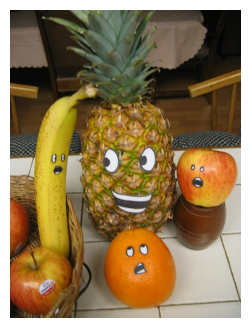

Caption: A banana, pineapple, apple, and orange have eyes and mouths.

Image: /home/saber/Wox/ANLP/multimodal_ai/data/COCO/train2014/COCO_train2014_000000163180.jpg

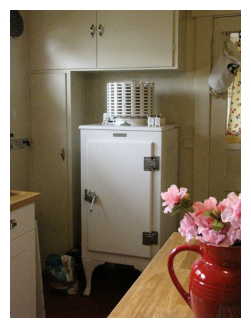

Caption: Flowers in a pitcher sit on the kitchen counter.

Image: /home/saber/Wox/ANLP/multimodal_ai/data/COCO/train2014/COCO_train2014_000000564789.jpg

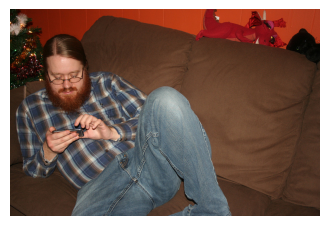

Caption: The man with a beard is using his cell phone while lying on a couch.

Image: /home/saber/Wox/ANLP/multimodal_ai/data/COCO/train2014/COCO_train2014_000000128113.jpg

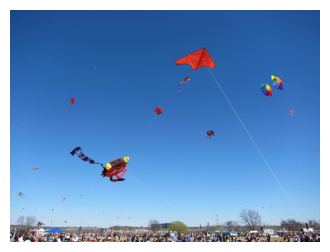

Caption: A bunch of people are flying their kites.

Image: /home/saber/Wox/ANLP/multimodal_ai/data/COCO/train2014/COCO_train2014_000000453582.jpg

In [11]:
# random samples along with actual image


sample_df = merged_df.sample(5)

for _, row in sample_df.iterrows():
    img = plt.imread(row["image_path"])
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    console.print(f"[bold]Caption:[/bold] {row['caption']}")
    console.print(f"[italic]Image:[/italic] {row['image_path']}\n")


In [13]:
annotations_df.head()

,image_id,id,caption
0,318556,48,A very clean and well decorated empty bathroom
1,116100,67,A panoramic view of a kitchen and all of its a...
2,318556,126,A blue and white bathroom with butterfly theme...
3,116100,148,A panoramic photo of a kitchen and dining room
4,379340,173,A graffiti-ed stop sign across the street from...


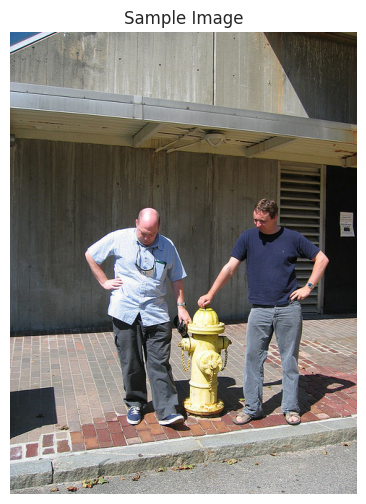

Captions:

- a couple of men are standing by  fire hydrant outside

- two men and a yellow fire hydrant and a building

- two guys that are standing next to a fire hydrogen

- Two men leaning on a yellow fire hydrant.

- The men are standing near the yellow fire hydrant.

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Pick a random image_id
random_image_id = merged_df["image_id"].sample(1).values[0]

image_rows = merged_df[merged_df["image_id"] == random_image_id]

image_path = image_rows["image_path"].iloc[0]

# Display image
img = Image.open(image_path)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image")
plt.show()

# Print all captions
console.print("\n[bold green]Captions:[/bold green]\n")
for cap in image_rows["caption"]:
    console.print(f"- {cap}")

In [15]:
# caption diversity per image

caption_counts = merged_df.groupby("image_id").size()

caption_counts.describe()

count    82783.000000
mean         5.002392
std          0.049094
min          5.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          7.000000
dtype: float64

In [16]:
# checking duplicate captions

duplicate_count = merged_df["caption"].duplicated().sum()
console.print(f"[bold red]Total Duplicate Captions:[/bold red] {duplicate_count}")

Total Duplicate Captions: 13151

In [17]:
# checking duplicates within same image

dup_within_image = (
    merged_df
    .groupby("image_id")["caption"]
    .apply(lambda x: x.duplicated().sum())
)

console.print(
    f"[bold yellow]Images with duplicate captions inside same image:[/bold yellow] "
    f"{(dup_within_image > 0).sum()}"
)

Images with duplicate captions inside same image: 102

In [18]:
# vocabulary and token analysis

all_words = []

for caption in tqdm(merged_df["caption"]):
    words = caption.lower().split()
    all_words.extend(words)

vocab = set(all_words)

console.print(f"[bold cyan]Vocabulary Size:[/bold cyan] {len(vocab)}")

100%|██████████| 414113/414113 [00:00<00:00, 1147209.06it/s]


Vocabulary Size: 37089

In [19]:
# caption length stats

merged_df["caption_length"].describe()

count    414113.000000
mean         10.458351
std           2.397105
min           5.000000
25%           9.000000
50%          10.000000
75%          11.000000
max          49.000000
Name: caption_length, dtype: float64

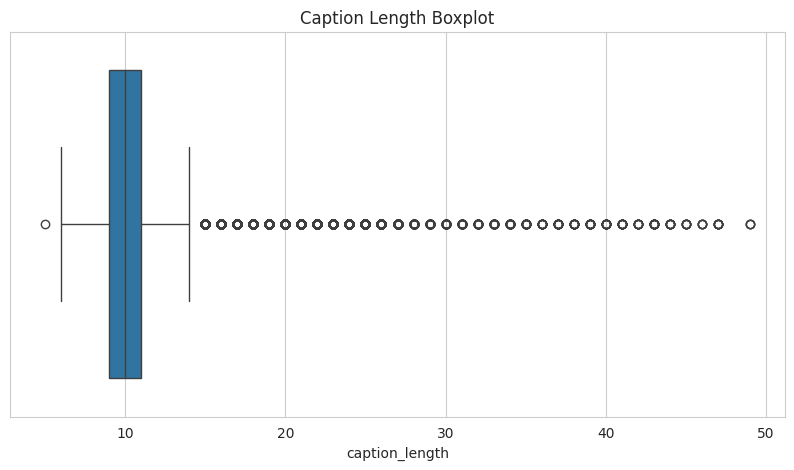

In [20]:
# caption length vs frequency

plt.figure(figsize=(10,5))
sns.boxplot(x=merged_df["caption_length"])
plt.title("Caption Length Boxplot")
plt.show()

In [22]:
# long captions

longest = merged_df.sort_values("caption_length", ascending=False).head(5)

for cap in longest["caption"]:
    console.print(cap)

Black night, a blurry shot shows a tall fence that angles, in a kind of Z shape, around what appears to be  a 
parking area  with a large building fronting it, as a kid with a red helmet takes a fierce swing in the batting 
area, inside the fence.

Two men holding tennis rackets up in a hand on either side of a man smiling, hugging a tennis racket to chest by 
tennis net on tennis course with many light green tennis balls in air in front of them and two balls on ground and 
"all play"sign behind.

From below view of the head, neck, and paws of a white dog with black spots looking at camera, with paws on window 
sill of an open window with left shutter closed and right shutter open, of a white brick building with rusty gutter
at top by blue sky.

A black and white shot shows a  bus interior with windows, hand rail,  and a woman, her eyes closed, as she holds a
bag on her lap, an empty seat, and a second, male passenger, holding a cell and reaching under his jacket, while 
holding a suitcase.

A blurry backdrop shows a wheel, resting on  dirt, and to the foreground, a man visible from  the top of his legs 
only, wearing a tag on his work shirt, suspenders, a hat and beard after the style of the Amish, who is holding a 
cell phone.